In [1]:
import xml.etree.ElementTree as ET
from tqdm import tqdm
from pathlib import Path
from tqdm import tqdm
import glob

In [2]:
train_class_names = ['pottedplant', 'sofa', 'tvmonitor', 'car', 'bottle', 'boat', 'chair', 'person', 'bus', 'train', 'horse', 'bicycle', 'dog', 'bird', 'motorbike', 'diningtable']
test_class_names = ['cow', 'sheep', 'cat', 'aeroplane']

In [ ]:
import os

paths = ['images',
         'images/train',
         'images/valid',
         'images/test',
         'labels',
         'labels/train',
         'labels/valid',
         'labels/test',
         'supports']

for path in paths:
    if not os.path.exists(path):
        os.mkdir(path)

for i in range(20):
    if not os.path.exists('supports/'+str(i)):
        os.mkdir('supports/'+str(i))    

In [ ]:
# !wget https://github.com/ultralytics/yolov5/releases/download/v1.0/VOCtrainval_06-Nov-2007.zip -o 'VOCtrainval_06-Nov-2007.zip' # 446MB, 5012 images
# !wget https://github.com/ultralytics/yolov5/releases/download/v1.0/VOCtest_06-Nov-2007.zip -o 'VOCtest_06-Nov-2007.zip' # 438MB, 4953 images
# !wget https://github.com/ultralytics/yolov5/releases/download/v1.0/VOCtrainval_11-May-2012.zip -o 'VOCtrainval_11-May-2012.zip' # 1.95GB, 17126 images

In [ ]:
# !unzip 'VOCtrainval_06-Nov-2007.zip.1'
# !unzip 'VOCtest_06-Nov-2007.zip.1'
# !unzip 'VOCtrainval_11-May-2012.zip.1'

In [ ]:
# !rm 'VOCtrainval_06-Nov-2007.zip.1'
# !rm 'VOCtest_06-Nov-2007.zip.1'
# !rm 'VOCtrainval_11-May-2012.zip.1'

In [ ]:
# Classes


def convert_box(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x, y, w, h = (box[0] + box[1]) / 2.0 - 1, (box[2] + box[3]) / 2.0 - 1, box[1] - box[0], box[3] - box[2]
    return x * dw, y * dh, w * dw, h * dh

names = {
    0: 'aeroplane',
    1: 'bicycle',
    2: 'bird',
    3: 'boat',
    4: 'bottle',
    5: 'bus',
    6: 'car',
    7: 'cat',
    8: 'chair',
    9: 'cow',
    10: 'diningtable',
    11: 'dog',
    12: 'horse',
    13: 'motorbike',
    14: 'person',
    15: 'pottedplant',
    16: 'sheep',
    17: 'sofa',
    18: 'train',
    19: 'tvmonitor',
}

from PIL import Image, ImageOps

def resize_with_padding(img, expected_size, colors=(114,114,114)):
    width, height = img.size
    ratio = width / height
    if width < height:
        img = img.resize((int(ratio*expected_size[0]),int(expected_size[0])))
    else:
        img = img.resize((int(expected_size[1]),int((1/ratio)*expected_size[1])))
        
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding, colors)

support_imgs = {i:0 for i in range(20)}

def resize_label_with_padding(old_size, expected_size, bbox):
    (x,y,w,h) = bbox

    ratio = old_size[0] / old_size[1]
    if old_size[0] < old_size[1]:
        new = (int(ratio*expected_size[0]),int(expected_size[0]))
    else:
        new = (int(expected_size[1]),int((1/ratio)*expected_size[1]))

    delta_width = expected_size[0] - new[0]
    delta_height = expected_size[1] - new[1]

    pad_width = delta_width // 2
    pad_height = delta_height // 2

    x_t = (pad_width +  (x)*new[0]) / expected_size[0]
    y_t = (pad_height + (y)*new[1]) / expected_size[1]
    w_t = w*new[0] / expected_size[0]
    h_t = h*new[1] / expected_size[1]
    
    return x_t,y_t,w_t,h_t

def convert_label(image, path, lb_path, year, image_id, classes):
    in_file = open(path / f'VOC{year}/Annotations/{image_id}.xml')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    name = list(names.values())  # names list
    good = False
    for obj in root.iter('object'):
        cls = obj.find('name').text
        cls_id = name.index(cls)  # class id
        if cls_id in classes and cls in name:# and int(obj.find('difficult').text) != 1: #OK ??
            xmlbox = obj.find('bndbox')
            x1, x2, y1, y2 = [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')]
            img = image.crop((x1,y1,x2,y2))
            img = resize_with_padding(img, (160,160), (0,0,0))
            img.save('supports/'+str(cls_id)+'/'+str(support_imgs[cls_id])+'.png')
            support_imgs[cls_id] = support_imgs[cls_id] + 1
            bb = convert_box((w, h), [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')])
            bb = resize_label_with_padding((w,h), (640,640), bb)
            with open(lb_path, 'a') as file:
                file.write(" ".join(str(a) for a in (cls_id, *bb)) + '\n')
            good = True
    return good

In [ ]:
# Convert
path = Path('VOCdevkit')

for year, image_set in ('2012', 'train'), ('2012', 'val'), ('2007', 'train'), ('2007', 'val'), ('2007', 'test'):
    imgs_path = Path('images')
    lbs_path = Path('labels')

    with open(path / f'VOC{year}/ImageSets/Main/{image_set}.txt') as f:
        image_ids = f.read().strip().split()

    for id in tqdm(image_ids, desc=f'{image_set}{year}'):
        
        f = path / f'VOC{year}/JPEGImages/{id}.jpg'  # old img path
        img = Image.open(f)

        if image_set == 'train' or image_set == 'val':
            img_path = (imgs_path / 'train' / f.name).with_suffix('.png')
            lb_path = (lbs_path / 'train' / f.name).with_suffix('.txt')
            classes = [i for i in range(20) if i not in [9, 16, 7, 0]]
            good = convert_label(img, path, lb_path, year, id, classes)  # convert labels to YOLO format
            if good:
                img = resize_with_padding(img, (640,640))
                img.save(img_path)

        if image_set == 'test':
            #Base validation
            img_path = (imgs_path / 'valid' / f.name).with_suffix('.png')
            lb_path = (lbs_path / 'valid' / f.name).with_suffix('.txt')
            classes = [i for i in range(20) if i not in [9, 16, 7, 0]] 
            good = convert_label(img, path, lb_path, year, id, classes)  # convert labels to YOLO format
            if good:
                img = resize_with_padding(img, (640,640))
                img.save(img_path)

            #Novel validation
            img_path = (imgs_path / 'test' / f.name).with_suffix('.png')
            lb_path = (lbs_path / 'test' / f.name).with_suffix('.txt')
            classes = [9, 16, 7, 0]
            good = convert_label(img, path, lb_path, year, id, classes)  # convert labels to YOLO format
            if good:
                img = resize_with_padding(img, (640,640))
                img.save(img_path)


train2012:   0%|          | 0/5717 [00:00<?, ?it/s]

test2007: 100%|██████████| 4952/4952 [01:56<00:00, 42.35it/s] 


In [ ]:
with open('data.yaml', 'wt') as f:
    f.write('train: images/train \n')
    f.write('val: images/valid \n')
    f.write('test: images/test \n')
    f.write('support: supports \n')
    f.write(' \n')
    f.write('nc: '+str(20)+'\n')

In [ ]:
#!rm -rf VOCdevkit

  0%|          | 0/6993 [00:00<?, ?it/s]

100%|██████████| 762/762 [00:00<00:00, 45376.02it/s]


Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19],
           dtype='int64')
20


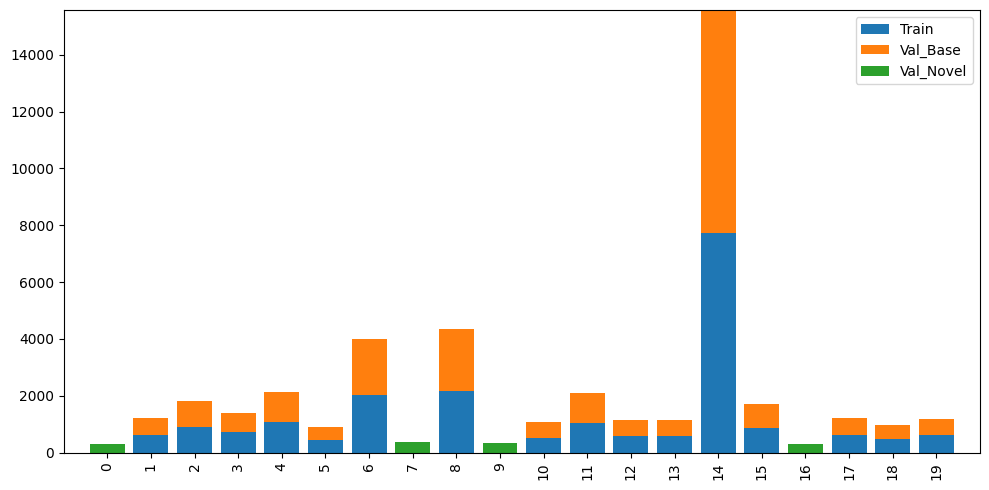

In [2]:
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_labels(file_paths):
    """Charge les labels de plusieurs fichiers et retourne une DataFrame."""
    labels = []
    for file_path in tqdm(file_paths):
        with open(file_path) as f:
            for line in f:
                labels.append(line.split(" ")[0])
    return pd.DataFrame({"support": labels})

def process_data(train_files, val_files, test_files):
    """Traite les fichiers et retourne un DataFrame combiné."""
    # Charger les données
    aa = load_labels(train_files).astype(int)
    bb = load_labels(val_files).astype(int)
    cc = load_labels(test_files).astype(int)

    # Comptage des valeurs
    counta = aa["support"].value_counts()
    countb = bb["support"].value_counts()
    countc = cc["support"].value_counts()

    # Fusionner les classes uniques
    classes = pd.concat([counta, countb, countc]).index.unique()
    classes = pd.to_numeric(classes).sort_values()

    return classes, counta, countb, countc

def plot_data(classes, counta, countb, countc):
    """Trace les graphiques de type barres empilées."""
    # Initialisation des dictionnaires avec 0 pour chaque classe
    listea = {cls: counta.get(cls, 0) for cls in classes}
    listeb = {cls: countb.get(cls, 0) for cls in classes}
    listec = {cls: countc.get(cls, 0) for cls in classes}

    # Créer un DataFrame pour les données de barres empilées
    df = pd.DataFrame({'Train': listea, 'Val': listeb, 'Test': listec}, index=classes)
    df = df.sort_index(ascending=True)

    position = range(len(df.index))

    # Créer le graphique
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(position, df['Train'], label='Train')
    ax.bar(position, df['Val'], bottom=df['Train'], label='Val_Base')
    ax.bar(position, df['Test'], bottom=df['Train'] + df['Val'], label='Val_Novel')

    # Ajouter les éléments au graphique
    ax.legend()
    ax.set_xticks(position)  # Définir seulement les positions de l'index existant
    ax.set_xticklabels(df.index, rotation=90)
    ax.set_xlim(min(position) - 1, max(position) + 1)
    plt.tight_layout()
    plt.show()

#plt.style.use("dark_background")

# Main
a = 'labels'
train_files = glob.glob(f'{a}/train/*.txt')
val_files = glob.glob(f'{a}/valid/*.txt')
test_files = glob.glob(f'{a}/test/*.txt')

classes, counta, countb, countc = process_data(train_files, val_files, test_files)
print(classes)
print(len(classes))
plot_data(classes, counta, countb, countc)